In [3]:
import networkx as nx
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm
from itertools import combinations
from collections import defaultdict, deque
import math, random
import heapq
import scipy.sparse as sp
from collections import deque
from joblib import Parallel, delayed
from numba import njit
from typing import Tuple, Dict, List, Set, Sequence, Union
import itertools

In [5]:
import math
import heapq
from typing import Tuple, Dict, List, Set

import networkx as nx
import numpy as np
from numba import njit, prange

def nx_to_csr(G: nx.Graph) -> Tuple[List[int], Dict[int, int], np.ndarray, np.ndarray, np.ndarray]:
     """Convert an undirected NetworkX graph (edge attr `'p'`) to CSR arrays."""
     nodes: List[int] = list(G.nodes())
     idx_of: Dict[int, int] = {u: i for i, u in enumerate(nodes)}

     indptr: List[int] = [0]
     indices: List[int] = []
     probs: List[float] = []

     for u in nodes:
         for v in G.neighbors(u):
             indices.append(idx_of[v])
             probs.append(G.edges[u, v]['p'])
         indptr.append(len(indices))

     return (
         nodes,
         idx_of,
         np.asarray(indptr, dtype=np.int32),
         np.asarray(indices, dtype=np.int32),
         np.asarray(probs, dtype=np.float32),
     )

@njit(inline="always")
def _bfs_component_size(start: int,
                    indptr: np.ndarray,
                    indices: np.ndarray,
                    probs: np.ndarray,
                    deleted: np.ndarray) -> int:
    """Return |C_u|−1 for **one** random realisation (stack BFS)."""
    n = deleted.size
    stack = np.empty(n, dtype=np.int32)
    visited = np.zeros(n, dtype=np.uint8)

    size = 1
    top = 0
    stack[top] = start
    top += 1
    visited[start] = 1

    while top:
        top -= 1
        v = stack[top]
        for eid in range(indptr[v], indptr[v + 1]):
            w = indices[eid]
            if deleted[w]:
                continue
            if np.random.random() >= probs[eid]:  # edge absent
                continue
            if visited[w]:
                continue
            visited[w] = 1
            stack[top] = w
            top += 1
            size += 1
    return size - 1

@njit(parallel=True)
def epc_mc(indptr: np.ndarray,
            indices: np.ndarray,
            probs: np.ndarray,
            deleted: np.ndarray,
            num_samples: int) -> float:
    """Monte‑Carlo estimator of **expected pairwise connectivity** (EPC)."""
    surv = np.where(~deleted)[0]
    m = surv.size
    if m < 2:
        return 0.0

    acc = 0.0
    for _ in prange(num_samples):
        u = surv[np.random.randint(m)]
        acc += _bfs_component_size(u, indptr, indices, probs, deleted)

    return (m * acc) / (2.0 * num_samples)

from typing import Tuple, Dict, List, Set, Sequence, Union

def greedy_cndp_epc_celf(
    G: nx.Graph,
    K: int,
    *,
    num_samples: int = 20_000,
    reuse_csr: Tuple = None,
    return_trace: bool = False,
) -> Union[Set[int], Tuple[Set[int], List[float]]]:
    """Select **K** nodes that minimise EPC using CELF & Numba.

    Parameters
    ----------
    return_trace : bool, default *False*
        If *True*, also return a list `[σ(S₁), σ(S₂), …]` where `S_i` is the
        prefix after deleting *i* nodes.  Useful for plots.
    """

    # CSR cache --------------------------------------------------------
    if reuse_csr is None:
        nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    else:
        nodes, idx_of, indptr, indices, probs = reuse_csr
    n = len(nodes)

    deleted = np.zeros(n, dtype=np.bool_)
    current_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

    pq: List[Tuple[float, int, int]] = []  # (-gain, v, last_round)
    gains = np.empty(n, dtype=np.float32)

    for v in range(n):
        deleted[v] = True
        gains[v] = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
        deleted[v] = False
        heapq.heappush(pq, (-gains[v], v, 0))

    S: Set[int] = set()
    trace: List[float] = []
    round_ = 0

    trace.append(current_sigma)

    while len(S) < K and pq:
        neg_gain, v, last = heapq.heappop(pq)
        if last == round_:
            # gain up‑to‑date → accept
            S.add(nodes[v])
            deleted[v] = True
            current_sigma += neg_gain  # add neg (= subtract gain)
            round_ += 1
            if return_trace:
                trace.append(current_sigma)
        else:
            # recompute gain lazily
            deleted[v] = True
            new_gain = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
            deleted[v] = False
            heapq.heappush(pq, (-new_gain, v, round_))

    return (S, trace) if return_trace else S

def optimise_epc(
     G: nx.Graph,
     K: int,
     *,
     num_samples: int = 20_000,
     return_trace: bool = False,
 ) -> Union[Set[int], Tuple[Set[int], List[float]]]:
     csr = nx_to_csr(G)
     return greedy_cndp_epc_celf(G, K, num_samples=num_samples, reuse_csr=csr, return_trace=return_trace)

In [4]:
er = nx.erdos_renyi_graph(100, 0.045, seed=42)
er.number_of_nodes(), er.number_of_edges() 

(100, 202)

In [11]:
t0 = time.perf_counter()

G = er.copy()
K = 10
p = 0.9

records = []
print(f"G: nodes: {G.number_of_nodes()} and edges: {G.number_of_edges()}")  

for p in tqdm(np.arange(0.0, 1.1, 0.1), desc="Processing", total=int(1.0/0.1)):
  def fresh_graph():
    H = G.copy()
    for u, v in H.edges():
      H[u][v]['p'] = p
    return H


  Sg, sigma_delta = optimise_epc(
    G=fresh_graph(), 
    K=K, 
    num_samples=100_000, 
    return_trace=True)
  t1 = time.perf_counter()
  t_greedy = t1 - t0

  print(f"P: {p} --- Greedy sigma(S): S: {Sg}")
  print(f"Time: {t_greedy:.4f}s")
  print(f"Sigma Delta: {sigma_delta}")

  records.append({
    'model': 'ER',
    'p': p,
    'algo': 'Greedy_optimise',
    'time': t_greedy,
    'epc': sigma_delta[-1],
  })

G: nodes: 100 and edges: 202


Processing:   0%|          | 0/10 [00:00<?, ?it/s]

P: 0.0 --- Greedy sigma(S): S: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Time: 0.0803s
Sigma Delta: [0.0, np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)]


Processing:  20%|██        | 2/10 [00:00<00:01,  7.18it/s]

P: 0.1 --- Greedy sigma(S): S: {96, 65, 34, 39, 10, 12, 52, 24, 90, 27}
Time: 0.2811s
Sigma Delta: [33.3345, np.float32(30.61674), np.float32(28.12502), np.float32(26.7235), np.float32(25.0032), np.float32(23.342924), np.float32(21.82539), np.float32(20.588804), np.float32(19.55276), np.float32(17.94429), np.float32(16.9677)]


Processing:  30%|███       | 3/10 [00:00<00:01,  3.97it/s]

P: 0.2 --- Greedy sigma(S): S: {96, 65, 34, 64, 42, 12, 22, 24, 90, 27}
Time: 0.6907s
Sigma Delta: [148.078, np.float32(126.06314), np.float32(112.3766), np.float32(100.75293), np.float32(90.89232), np.float32(82.53695), np.float32(74.21018), np.float32(67.53427), np.float32(60.4095), np.float32(55.025425), np.float32(49.3155)]


Processing:  40%|████      | 4/10 [00:02<00:04,  1.39it/s]

P: 0.30000000000000004 --- Greedy sigma(S): S: {96, 65, 34, 5, 10, 12, 54, 24, 90, 27}
Time: 2.1888s
Sigma Delta: [716.556, np.float32(575.1039), np.float32(481.44116), np.float32(401.1862), np.float32(338.1115), np.float32(286.77414), np.float32(243.17094), np.float32(203.29893), np.float32(171.75526), np.float32(144.89474), np.float32(122.0985)]


Processing:  50%|█████     | 5/10 [00:05<00:08,  1.66s/it]

P: 0.4 --- Greedy sigma(S): S: {96, 65, 34, 5, 10, 12, 54, 24, 90, 27}
Time: 5.6269s
Sigma Delta: [2130.0025, np.float32(1854.754), np.float32(1618.7253), np.float32(1386.8613), np.float32(1166.2699), np.float32(984.77094), np.float32(801.40497), np.float32(661.83636), np.float32(531.33954), np.float32(422.87836), np.float32(333.7911)]


Processing:  60%|██████    | 6/10 [00:10<00:10,  2.61s/it]

P: 0.5 --- Greedy sigma(S): S: {96, 65, 34, 64, 10, 12, 54, 24, 90, 27}
Time: 10.1567s
Sigma Delta: [3296.7115, np.float32(3036.2507), np.float32(2749.8257), np.float32(2527.5625), np.float32(2281.4458), np.float32(2026.9794), np.float32(1831.653), np.float32(1576.004), np.float32(1363.3062), np.float32(1081.5063), np.float32(904.93066)]


Processing:  70%|███████   | 7/10 [00:15<00:10,  3.55s/it]

P: 0.6000000000000001 --- Greedy sigma(S): S: {0, 65, 34, 96, 64, 43, 54, 24, 90, 27}
Time: 15.6872s
Sigma Delta: [3944.8435, np.float32(3711.8247), np.float32(3445.8), np.float32(3261.51), np.float32(3083.3318), np.float32(2854.8103), np.float32(2673.0784), np.float32(2512.754), np.float32(2360.1704), np.float32(2198.9126), np.float32(1980.6075)]


Processing:  80%|████████  | 8/10 [00:21<00:08,  4.22s/it]

P: 0.7000000000000001 --- Greedy sigma(S): S: {0, 65, 64, 34, 59, 43, 50, 24, 27, 94}
Time: 21.3600s
Sigma Delta: [4314.5055, np.float32(4117.814), np.float32(3880.8074), np.float32(3702.7295), np.float32(3542.6836), np.float32(3384.0972), np.float32(3234.0615), np.float32(3091.0776), np.float32(2950.5422), np.float32(2740.1929), np.float32(2599.259)]


Processing:  90%|█████████ | 9/10 [00:27<00:04,  4.72s/it]

P: 0.8 --- Greedy sigma(S): S: {0, 64, 65, 6, 27, 47, 79, 50, 59, 94}
Time: 27.2009s
Sigma Delta: [4534.506, np.float32(4343.319), np.float32(4171.3774), np.float32(4007.1145), np.float32(3839.5532), np.float32(3689.6028), np.float32(3543.2427), np.float32(3390.8962), np.float32(3244.5935), np.float32(3122.9749), np.float32(2978.034)]


Processing: 100%|██████████| 10/10 [00:33<00:00,  5.30s/it]

P: 0.9 --- Greedy sigma(S): S: {0, 64, 6, 27, 43, 47, 50, 59, 93, 94}
Time: 33.8096s
Sigma Delta: [4670.8375, np.float32(4475.404), np.float32(4297.022), np.float32(4123.017), np.float32(3948.9802), np.float32(3783.9165), np.float32(3617.0894), np.float32(3455.4995), np.float32(3300.1467), np.float32(3199.5413), np.float32(3094.9712)]


Processing: 11it [00:42,  3.86s/it]                        

P: 1.0 --- Greedy sigma(S): S: {0, 64, 96, 6, 71, 43, 47, 50, 59, 94}
Time: 42.4360s
Sigma Delta: [4754.6005, np.float32(4556.6284), np.float32(4370.482), np.float32(4186.3813), np.float32(3998.0366), np.float32(3821.0334), np.float32(3653.5874), np.float32(3487.56), np.float32(3322.7722), np.float32(3232.866), np.float32(3151.3652)]


In [13]:
df = pd.DataFrame(records)
df

,model,p,algo,time,epc
0,ER,0.0,Greedy_optimise,0.080262,0.000000
1,ER,0.1,Greedy_optimise,0.281129,16.967699
2,ER,0.2,Greedy_optimise,0.690685,49.315498
3,ER,0.3,Greedy_optimise,2.188834,122.098503
4,ER,0.4,Greedy_optimise,5.626892,333.791107
5,ER,0.5,Greedy_optimise,10.156736,904.930664
6,ER,0.6,Greedy_optimise,15.687237,1980.607544
7,ER,0.7,Greedy_optimise,21.359973,2599.259033
8,ER,0.8,Greedy_optimise,27.200900,2978.033936
9,ER,0.9,Greedy_optimise,33.809625,3094.971191


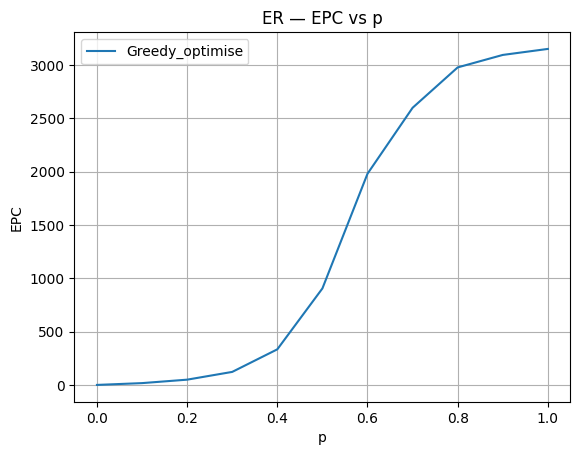

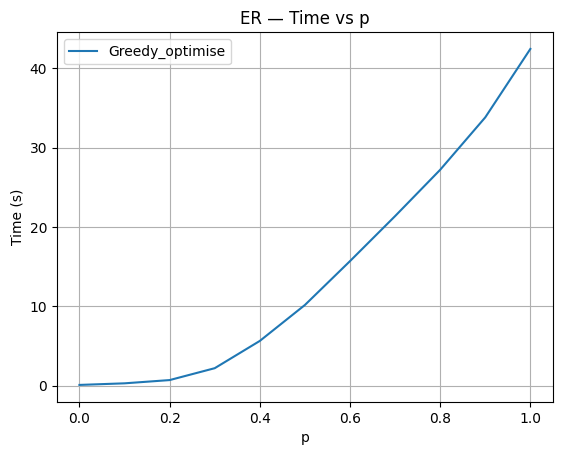

In [14]:
plt.figure()
for algo in df.algo.unique():
    sub = df[(df.model == 'ER') & (df.algo == algo)]
    plt.plot(sub.p, sub.epc, label=algo)
plt.title(f"{'ER'} — EPC vs p")
plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()
plt.savefig(f"{'ER'}_epc_vs_p.png")

plt.figure()
for algo in df.algo.unique():
    sub = df[(df.model == 'ER') & (df.algo == algo)]
    plt.plot(sub.p, sub.time, label=algo)
plt.title(f"{'ER'} — Time vs p")
plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
plt.savefig(f"{'ER'}_time_vs_p.png")
plt.show()

In [8]:
# @njit
# def _uf_find(parent, i):
#     while parent[i] != i:
#         parent[i] = parent[parent[i]]
#         i = parent[i]
#     return i

# @njit
# def _uf_union(parent, size, a, b):
#     ra, rb = _uf_find(parent, a), _uf_find(parent, b)
#     if ra == rb:
#         return
#     # union by size (small → big)
#     if size[ra] < size[rb]:
#         ra, rb = rb, ra
#     parent[rb] = ra
#     size[ra] += size[rb]


# @njit(parallel=True)
# def _epc_mc_numba(n, u, v, p, removed_mask, n_samples):
#     """
#     Parallel Monte-Carlo EPC estimate.
#     removed_mask : boolean array length n (True ⇒ node deleted)
#     """
#     m = u.shape[0]
#     epc_sum = 0.0

#     for s in prange(n_samples):
#         parent = np.arange(n, dtype=np.int32)
#         size   = np.ones(n,  dtype=np.int32)

#         for e in range(m):
#             if np.random.rand() < p[e]:
#                 a, b = u[e], v[e]
#                 if removed_mask[a] or removed_mask[b]:
#                     continue
#                 _uf_union(parent, size, a, b)

#         seen = np.zeros(n, np.uint8)
#         for i in range(n):
#             if removed_mask[i]:
#                 continue
#             r = _uf_find(parent, i)
#             if seen[r]:
#                 continue
#             seen[r] = 1
#             k = size[r]
#             epc_sum += k * (k - 1) / 2.0

#     return epc_sum / n_samples

# def nx_to_arrays(G):
#     """
#     Convert an undirected NetworkX graph with edge attribute 'p'
#     into flat NumPy arrays (u, v, p) for numba kernels.
#     """
#     n = G.number_of_nodes()
#     m = G.number_of_edges()
#     u = np.empty(m, dtype=np.int32)
#     v = np.empty(m, dtype=np.int32)
#     p = np.empty(m, dtype=np.float32)
#     for idx, (a, b, d) in enumerate(G.edges(data=True)):
#         u[idx] = a
#         v[idx] = b
#         p[idx] = d['p']
#     return n, u, v, p

# def component_sampling_epc_mc(G_prob, removed_set, n_samples=1000):
#     """
#     Fast drop-in EPC estimator (Algorithm 2 in the paper) using numba.
#     """
#     n, u, v, p = nx_to_arrays(G_prob)
#     removed_mask = np.zeros(n, dtype=np.bool_)
#     for node in removed_set:
#         removed_mask[node] = True
#     return _epc_mc_numba(n, u, v, p, removed_mask, n_samples)

In [9]:
def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
  bc = nx.betweenness_centrality(G)
  topk = sorted(bc, key=bc.get, reverse=True)[:k]
  H = G.copy()
  H.remove_nodes_from(topk)
  return H

def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
  L = nx.line_graph(G)
  pr = nx.pagerank(L)
  topk = sorted(pr, key=pr.get, reverse=True)[:k]
  H = G.copy()
  H.remove_edges_from(topk)
  return H

In [15]:
from typing import Any

def remove_k_pagerank_nodes(
    G: nx.Graph,
    k: int,
    *,
    pagerank_kwargs: Dict[str, Any] | None = None,
) -> nx.Graph:
    """
    Return a copy of *G* after deleting the k nodes with the
    highest PageRank scores.

    Parameters
    ----------
    G : nx.Graph
        Input graph (directed or undirected).
    k : int
        Number of nodes to delete.
    pagerank_kwargs : dict, optional
        Extra keyword arguments forwarded to ``nx.pagerank``;
        e.g. ``alpha=0.85``, ``weight="weight"``, ``max_iter=100`` …
        Leave empty to accept NetworkX defaults.

    Notes
    -----
    * On an **undirected** graph, PageRank reduces to a
      normalized eigenvector centrality, so the ranking you get is
      equivalent to “importance” in many other centrality measures.
    * If your graph already stores an edge‐probability attribute
      (e.g. ``'p'`` from your EPC experiments), you usually **don’t**
      want to feed that into PageRank as a weight—leave ``weight=None``.
      Otherwise high-probability *missing* edges distort the walk.
    """
    pagerank_kwargs = {} if pagerank_kwargs is None else dict(pagerank_kwargs)

    # 1. Compute PR on the node set
    pr = nx.pagerank(G, **pagerank_kwargs)

    # 2. Pick the k nodes with largest score
    topk = sorted(pr, key=pr.get, reverse=True)[:k]

    # 3. Remove and return a fresh graph
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

In [10]:
def component_sampling_epc_mc(G, S, num_samples=10_000,
                              epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """

  # Surviving vertex set and its size
  V_remaining = set(G.nodes()) - S
  n_rem = len(V_remaining)

  # base case
  if n_rem < 2:
    return 0.0

  if num_samples is None:
    assert epsilon is not None and delta is not None
    P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())
    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    num_samples = math.ceil(coeff * n_rem * (n_rem - 1) /
                            (epsilon ** 2 * P_E))

  C2 = 0
  it = tqdm(range(num_samples), desc='Component sampling',
            total=num_samples) if use_tqdm else range(num_samples)

  for _ in it:
    u = random.choice(tuple(V_remaining))

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:

      v = queue.pop()
      for w in G.neighbors(v):

        # flip a coin biased by the edge probability
        # w not in deleted nodes
        if w in V_remaining and random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
              visited.add(w)
              queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  return (n_rem * C2) / (2 * num_samples)

In [ ]:
K = 10

G = er.copy()

print(f"G: nodes: {G.number_of_nodes()} and edges: {G.number_of_edges()}")  

records1 = []

for p in tqdm(np.arange(0.0, 1.1, 0.1), desc="Processing", total=int(1.1/0.1)):
  def fresh_graph():
    H = G.copy()
    for u, v in H.edges():
      H[u][v]['p'] = p
    return H

  t0 = time.perf_counter()
  G_bc  = remove_k_betweenness(fresh_graph(), K)
  t_bc  = time.perf_counter() - t0

  epc_bc = component_sampling_epc_mc(G_bc, set(), 100_000)

  # PageRank
  t0 = time.perf_counter()
  G_pr  = remove_k_pagerank_nodes(fresh_graph(), K)
  t_pr  = time.perf_counter() - t0
  epc_pr = component_sampling_epc_mc(G_pr, set(), 100_000)

  records1.append({
    'model': 'ER',
    'p': p,
    'algo': 'Betweenness',
    'time': t_bc,
    'epc': epc_bc,
  })

  records1.append({
    'model': 'ER',
    'p': p,
    'algo': 'PageRank',
    'time': t_pr,
    'epc': epc_pr,
  })

G: nodes: 100 and edges: 202


Processing: 11it [00:57,  5.27s/it]                        


In [17]:
df1 = pd.DataFrame(records1)
df1

,model,p,algo,time,epc
0,ER,0.0,Betweenness,0.009783,0.00000
1,ER,0.0,PageRank,0.001651,0.00000
2,ER,0.1,Betweenness,0.008933,17.25660
3,ER,0.1,PageRank,0.001766,16.94970
4,ER,0.2,Betweenness,0.009299,52.73370
5,ER,0.2,PageRank,0.002078,50.87925
6,ER,0.3,Betweenness,0.009217,145.37205
7,ER,0.3,PageRank,0.001641,134.95950
8,ER,0.4,Betweenness,0.009183,408.72060
9,ER,0.4,PageRank,0.001647,383.70825


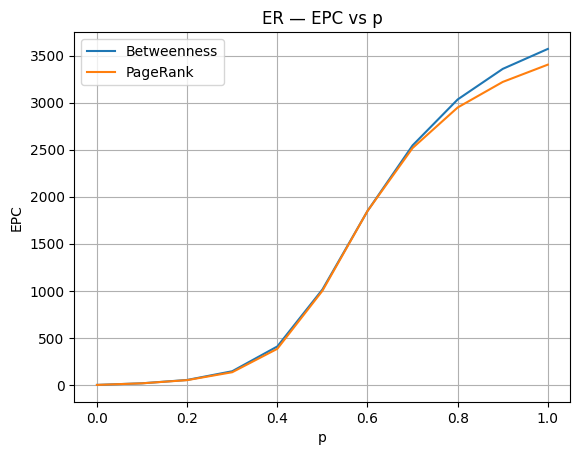

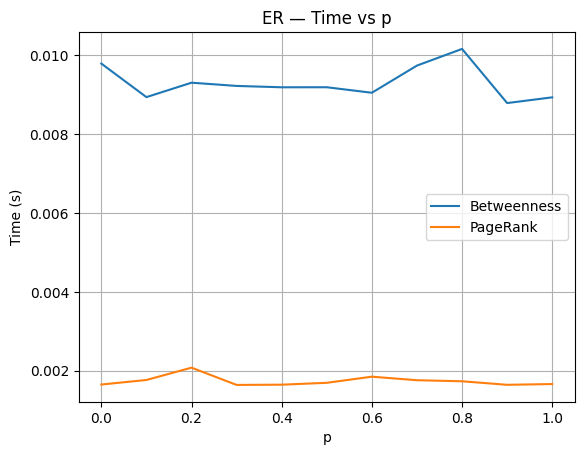

In [18]:
plt.figure()
for algo in df1.algo.unique():
    sub = df1[(df1.model == 'ER') & (df1.algo == algo)]
    plt.plot(sub.p, sub.epc, label=algo)
plt.title(f"{'ER'} — EPC vs p")
plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()
plt.savefig(f"{'ER'}_epc_vs_p.png")

plt.figure()
for algo in df1.algo.unique():
    sub = df1[(df1.model == 'ER') & (df1.algo == algo)]
    plt.plot(sub.p, sub.time, label=algo)
plt.title(f"{'ER'} — Time vs p")
plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
plt.savefig(f"{'ER'}_time_vs_p.png")
plt.show()

In [19]:
def solve_lp_relaxation(G: nx.Graph, D: set, k: int) -> dict:
  nodes = list(G.nodes())
  n = len(nodes)
  edges = list(G.edges())
  m = len(edges)

  idx_s = {nodes[i]: i for i in range(n)}
  idx_z = {edges[j]: n + j for j in range(m)}

  bounds = [(0,1)] * (n + m)
  for u in D:
      bounds[idx_s[u]] = (1,1)

  A_eq = np.zeros((1, n + m))
  for u in nodes:
      A_eq[0, idx_s[u]] = 1
  b_eq = [k]

  A_ub, b_ub = [], []
  for (u, v) in edges:
      iu, iv = idx_s[u], idx_s[v]
      iz = idx_z[(u, v)]
      row = np.zeros(n + m); row[iu] = 1; row[iz] = 1
      A_ub.append(row); b_ub.append(1)
      row = np.zeros(n + m); row[iv] = 1; row[iz] = 1
      A_ub.append(row); b_ub.append(1)
      row = np.zeros(n + m); row[iz] = -1; row[iu] = -1; row[iv] = -1
      A_ub.append(row); b_ub.append(-1)
  A_ub = np.array(A_ub); b_ub = np.array(b_ub)

  c = np.zeros(n + m)
  for j, (u, v) in enumerate(edges):
      c[n + j] = G.edges[u, v]['p']

  res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                bounds=bounds, method='highs')
  if not res.success:
      raise RuntimeError("LP infeasible: " + res.message)
  return {nodes[i]: float(res.x[idx_s[nodes[i]]]) for i in range(n)}

def REGA_with_LP(G: nx.Graph, k: int, R: int, alpha: float) -> set:
  best_S, best_obj = None, float('inf')
  nodes = set(G.nodes())

  for _ in range(R):
      D = set()
      for _ in range(k):
          s_vals = solve_lp_relaxation(G, D, k)
          rem = list(nodes - D)
          sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
          m = max(1, int(alpha * len(sorted_nodes)))
          D.add(random.choice(sorted_nodes[:m]))
      current_obj = component_sampling_epc_mc(G, D, 1000)
      improved = True
      while improved:
          improved = False
          for u in list(D):
              for v in nodes - D:
                  newS = (D - {u}) | {v}
                  val = component_sampling_epc_mc(G, newS, 1000)
                  if val < current_obj:
                      D, current_obj, improved = newS, val, True
                      break
              if improved:
                  break
      if current_obj < best_obj:
          best_S, best_obj = D.copy(), current_obj
  return best_S

In [20]:


er = nx.erdos_renyi_graph(100, 0.045, seed=42)

G = er.copy()
K = 10

records2 = []
print(f"G: nodes: {G.number_of_nodes()} and edges: {G.number_of_edges()}")  

for p in tqdm(np.arange(0.0, 1.1, 0.1), desc="Processing", total=int(1.0/0.1)):
  def fresh_graph():
    H = G.copy()
    for u, v in H.edges():
      H[u][v]['p'] = p
    return H

  t0 = time.perf_counter()
  S_rega = REGA_with_LP(G=fresh_graph(), k=K, R=5, alpha=0.3)
  t1 = time.perf_counter()
  t_rega = t1 - t0
  epc_rega = component_sampling_epc_mc(fresh_graph(), S_rega, 100_000)

  print(f"REGA sigma(S): S: {epc_rega}")
  print(f"Time: {t_rega:.4f}s")

  records2.append({
    'model': 'ER',
    'p': p,
    'algo': 'Greedy',
    'time': t_rega,
    'epc': epc_rega,
  })

G: nodes: 100 and edges: 202


Processing:  10%|█         | 1/10 [00:07<01:04,  7.14s/it]

REGA sigma(S): S: 0.0
Time: 6.9916s


Processing:  20%|██        | 2/10 [00:35<02:36, 19.56s/it]

REGA sigma(S): S: 20.06775
Time: 35.2071s


Processing:  30%|███       | 3/10 [01:17<03:27, 29.68s/it]

REGA sigma(S): S: 54.2295
Time: 76.8545s


Processing:  40%|████      | 4/10 [04:13<08:45, 87.59s/it]

REGA sigma(S): S: 121.7142
Time: 253.0782s


Processing:  50%|█████     | 5/10 [11:41<18:08, 217.72s/it]

REGA sigma(S): S: 333.6237
Time: 701.1214s


Processing:  60%|██████    | 6/10 [30:23<34:59, 524.88s/it]

REGA sigma(S): S: 874.20465
Time: 1821.2564s


Processing:  70%|███████   | 7/10 [1:01:02<47:44, 954.76s/it]

REGA sigma(S): S: 1718.2548
Time: 3659.5269s


Processing:  80%|████████  | 8/10 [1:32:16<41:34, 1247.44s/it]

REGA sigma(S): S: 2354.1903
Time: 5532.3183s


Processing:  90%|█████████ | 9/10 [1:59:35<22:49, 1369.69s/it]

REGA sigma(S): S: 2506.4757
Time: 7170.5342s


Processing: 100%|██████████| 10/10 [2:25:03<00:00, 1418.72s/it]

REGA sigma(S): S: 2800.96605
Time: 8698.4643s


Processing: 11it [2:56:59, 965.38s/it]                         

REGA sigma(S): S: 2855.66265
Time: 10613.5038s


In [22]:
df2 = pd.DataFrame(records2)
df2.to_csv(f"Rega_100_200_ER.csv", index=False)

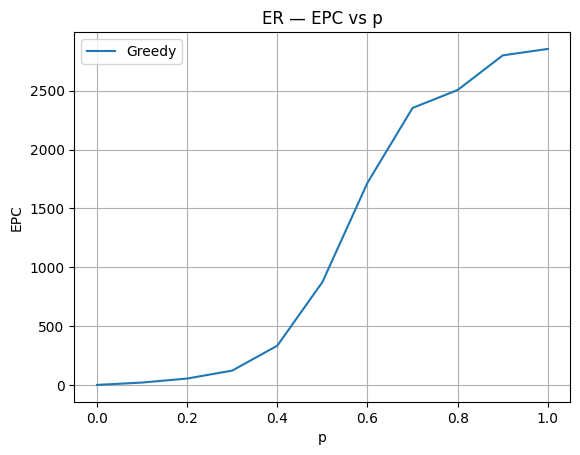

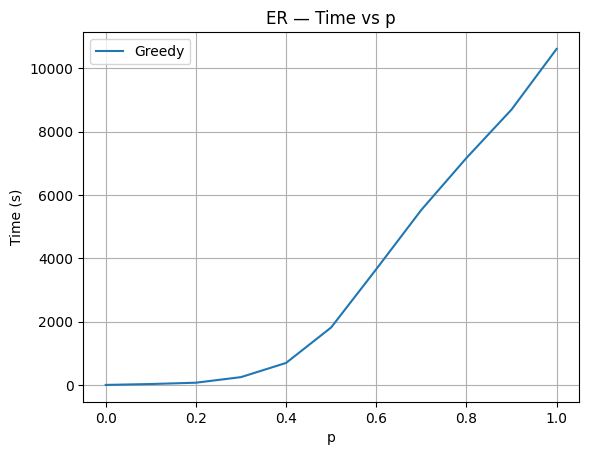

In [23]:
plt.figure()
for algo in df2.algo.unique():
    sub = df2[(df2.model == 'ER') & (df2.algo == algo)]
    plt.plot(sub.p, sub.epc, label=algo)
plt.title(f"{'ER'} — EPC vs p")
plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()
plt.savefig(f"{'ER'}_epc_vs_p.png")

plt.figure()
for algo in df2.algo.unique():
    sub = df2[(df2.model == 'ER') & (df2.algo == algo)]
    plt.plot(sub.p, sub.time, label=algo)
plt.title(f"{'ER'} — Time vs p")
plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
plt.savefig(f"{'ER'}_time_vs_p.png")
plt.show()

### REGA - Sparse Variant

In [24]:
import numpy as np
import scipy.sparse as sp
from scipy.optimize import linprog

def solve_lp_relaxation_sparse(G, D, k):
    nodes = list(G.nodes())
    n = len(nodes)

    edges = list(G.edges())
    m = len(edges)

    idx_s = {nodes[i]: i for i in range(n)}
    idx_z = {edges[j]: n + j for j in range(m)}

    # ------------------------ bounds ------------------------
    bounds = [(0, 1)] * (n + m)
    for u in D:                       # force deleted nodes
        bounds[idx_s[u]] = (1, 1)

    # ------------------------ equality Σ s_u = k --------
    data_eq, rows_eq, cols_eq = [], [], []
    for u in nodes:
        data_eq.append(1.0)
        rows_eq.append(0)
        cols_eq.append(idx_s[u])
    A_eq = sp.csr_matrix((data_eq, (rows_eq, cols_eq)),
                         shape=(1, n + m))
    b_eq = np.array([k], dtype=float)

    # ------------------------ inequalities -----------------
    data, rows, cols = [], [], []
    b_ub = []

    row_id = 0
    for (u, v) in edges:
        iu, iv = idx_s[u], idx_s[v]
        iz = idx_z[(u, v)]

        # s_u + z_uv ≤ 1
        data.extend([1, 1])
        rows.extend([row_id, row_id])
        cols.extend([iu, iz])
        b_ub.append(1); row_id += 1

        # s_v + z_uv ≤ 1
        data.extend([1, 1])
        rows.extend([row_id, row_id])
        cols.extend([iv, iz])
        b_ub.append(1); row_id += 1

        # –s_u – s_v – z_uv ≤ –1    (i.e. 1 ≤ s_u + s_v + z_uv)
        data.extend([-1, -1, -1])
        rows.extend([row_id]*3)
        cols.extend([iu, iv, iz])
        b_ub.append(-1); row_id += 1

    A_ub = sp.csr_matrix((data, (rows, cols)),
                         shape=(row_id, n + m))
    b_ub = np.asarray(b_ub, dtype=float)

    # ------------------------ objective --------------------
    c = np.zeros(n + m)
    for j, (u, v) in enumerate(edges):
        c[n + j] = G.edges[u, v]['p']      # minimise expected connectivity

    res = linprog(c, A_ub=A_ub, b_ub=b_ub,
                  A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds,
                  method='highs')          # HiGHS auto-detects CSR
    if not res.success:
        raise RuntimeError(f"LP infeasible: {res.message}")

    return {u: float(res.x[idx_s[u]]) for u in nodes}

def REGA_with_LP(G: nx.Graph, k: int, R: int, alpha: float) -> set:
  best_S, best_obj = None, float('inf')
  nodes = set(G.nodes())

  for _ in range(R):
      D = set()
      for _ in range(k):
          s_vals = solve_lp_relaxation_sparse(G, D, k)
          rem = list(nodes - D)
          sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
          m = max(1, int(alpha * len(sorted_nodes)))
          D.add(random.choice(sorted_nodes[:m]))
      current_obj = component_sampling_epc_mc(G, D, 1000)
      improved = True
      while improved:
          improved = False
          for u in list(D):
              for v in nodes - D:
                  newS = (D - {u}) | {v}
                  val = component_sampling_epc_mc(G, newS, 1000)
                  if val < current_obj:
                      D, current_obj, improved = newS, val, True
                      break
              if improved:
                  break
      if current_obj < best_obj:
          best_S, best_obj = D.copy(), current_obj
  return best_S

In [27]:
from pulp import (
    LpProblem, LpVariable, lpSum,
    LpBinary, LpMinimize, PULP_CBC_CMD, LpStatus
)

def sample_scenarios(G_prob, T=30, rng=None):
    rng = rng or random.Random()
    scenarios = []
    for _ in range(T):
        H = nx.Graph()
        H.add_nodes_from(G_prob.nodes)
        for u, v, d in G_prob.edges(data=True):
            if rng.random() < d['p']:
                H.add_edge(u, v)
        scenarios.append(H)
    return scenarios

def solve_saa_mip_cbc(scenarios, k, msg=False):
    """
    Solve the SAA master problem with CBC and return initial set S₀ (|S₀|=k).
    """
    n = len(scenarios[0])
    T = len(scenarios)
    prob = LpProblem("k-pCND-SAA-CBC", LpMinimize)

    s = [LpVariable(f"s_{i}", cat=LpBinary) for i in range(n)]

    x = {}
    for l, H in enumerate(scenarios):
        for i, j in itertools.combinations(range(n), 2):
            x[(l, i, j)] = LpVariable(f"x_{l}_{i}_{j}", cat=LpBinary)
        for i in range(n):
            x[(l, i, i)] = 1

    prob += lpSum(s) == k

    for l, H in enumerate(scenarios):
        for i, j in itertools.combinations(range(n), 2):
            prob += x[(l, i, j)] <= 1 - s[i]
            prob += x[(l, i, j)] <= 1 - s[j]

        for i, j in itertools.combinations(range(n), 2):
            if not nx.has_path(H, i, j):
                prob += x[(l, i, j)] == 0

        for i, h, j in itertools.permutations(range(n), 3):
            ij = tuple(sorted((i, j)))
            ih = tuple(sorted((i, h)))
            hj = tuple(sorted((h, j)))
            prob += x[(l, ij[0], ij[1])] <= x[(l, ih[0], ih[1])]
            prob += x[(l, ij[0], ij[1])] <= x[(l, hj[0], hj[1])]

    prob += (1 / T) * lpSum(x.values())

    status = prob.solve(PULP_CBC_CMD(msg=msg))
    if LpStatus[status] != "Optimal":
        print("⚠ CBC ended with status:", LpStatus[status])

    S0 = {i for i in range(n) if s[i].value() > 0.5}
    return S0

def local_search(G_prob, S0, num_samples=10_000, max_iter=1000, seed=None):
    rng = random.Random(seed)
    S = set(S0)
    best_val = component_sampling_epc_mc(G_prob, S, num_samples)
    for _ in tqdm(range(max_iter), desc="Local_search", total=max_iter):
        improved = False
        for u in list(S):
            # random permutation of outside nodes
            outside = rng.sample(list(set(G_prob.nodes) - S), len(G_prob) - len(S))
            for v in outside:
                candidate = (S - {u}) | {v}      # keeps size = k
                val = component_sampling_epc_mc(G_prob, candidate, num_samples)
                if val < best_val:
                    S, best_val = candidate, val
                    improved = True
                    break
            if improved:
                break
        if not improved:
            break
    return S, best_val

def final_evaluation(G_prob, S, num_samples=100_000):
    return component_sampling_epc_mc(G_prob, S, num_samples)

def saa_algorithm(G_prob, k, T=30, ls_samples=10_000, seed=None):
    """
    Full 4-phase SAA algorithm (CBC core + numba EPC).
    Returns
    -------
    S_best      : set[int]       # final deletion set (size = k)
    epc_est     : float          # EPC estimate after local search (ls_samples draws)
    epc_final   : float          # high-accuracy EPC (100 000 draws)
    """
    scenarios = sample_scenarios(G_prob, T, rng=random.Random(seed))

    S0 = solve_saa_mip_cbc(scenarios, k, msg=False)
    S_best, epc_est = local_search(G_prob, S0, ls_samples, seed=seed)

    epc_final = final_evaluation(G_prob, S_best)

    return S_best, epc_est, epc_final

In [ ]:
M = 0.0443

er = nx.erdos_renyi_graph(100, 0.045, seed=42)

G = er.copy()
K = 10

records5 = []
print(f"G: nodes: {G.number_of_nodes()} and edges: {G.number_of_edges()}")  

for p in tqdm(np.arange(0.0, 1.1, 0.1), desc="Processing", total=int(1.1/0.1)):
  def fresh_graph():
    H = G.copy()
    for u, v in H.edges():
      H[u][v]['p'] = p
    return H

  t0 = time.perf_counter()
  S_best, epc_est, epc_final = saa_algorithm(fresh_graph(), k=K, T=30, ls_samples=1000)
  t1 = time.perf_counter()
  t_saa = t1 - t0
  
  print(f"SAA S: S_best {S_best}")
  print(f"SAA sigma(S): {epc_final}")
  print(f"Time: {t_saa:.4f}s")

  records5.append({
    'model': 'ER',
    'p': p,
    'algo': 'SAA',
    'time': t_saa,
    'epc': epc_final,
  })

G: nodes: 100 and edges: 202


Processing:   0%|          | 0/11 [00:00<?, ?it/s]

: 

In [ ]:
df5 = pd.DataFrame(records5)
df5.to_csv("SAA_100_202_ER.csv", index=False)